# つくりながら学ぶ！深層強化学習 PyTorchによる実践プログラミング

## 迷路問題

前回までで、行動反復法と価値反復法による強化学習アルゴリズムを実装してきた

今回は、これらのアルゴリズムを選択して強化学習できるようにフレームワークを作成して汎用化してみる

## モジュール分割

ここまで作ってきた迷路問題のコードを分割してみる

まずは、強化学習なしで単純にエージェントを動かす部分だけを考える（[01_01-maze.ipynb](./01_01-maze.ipynb) まで）

- 方策 (Policy): 次の行動を決めるための機能
    - インターフェイス:
        - 行動決定: `(現在の状態) -> (次の行動)`
    - 実装:
        - 表形式方策: 予め設定された方策パラメータ（行動確率）に従って行動を決定
- 記録者 (Recorder): エージェントの状態・行動を記録するための機能
    - インターフェイス:
        - 記録取得: `() -> (記録データ)`
        - 記録実行: `(現在の実行, 次の行動)!`
    - 実装:
        - 配列式記録者: 状態・行動のタプルを配列にして記録する
- 強化学習環境 (Env): エージェントの行動や状態等の環境を定義するための機能
    - インターフェイス:
        - 行動空間取得: `() -> (行動空間)`
        - 状態空間取得: `() -> (状態空間)`
        - 報酬取得: `() -> (報酬)`
        - 終了判定: `() -> (終了フラグ)`
        - 初期化: `()!`
        - 現在の状態取得: `() -> (状態)`
        - 状態遷移: `(行動)!`
    - 関数:
        - 行動決定: `(方策) -> (行動)`
        - シナリオ実行: `(方策, 記録者)!`
    - 実装:
        - 迷路問題環境: 迷路問題を解くための環境

In [1]:
using NaNStatistics, Distributions

"再定義可能な構造体を定義するマクロ"
macro restruct(exp)
    tmpname = "var\"$(gensym())\""
    mutable = exp.args[1] ? "mutable" : ""
    name, extend = if typeof(exp.args[2]) === Expr
        if exp.args[2].head === :curly
            (exp.args[2].args[1], "{$(exp.args[2].args[2])}")
        else
            (exp.args[2].args[1], "<: $(exp.args[2].args[2])")
        end
    else
        (exp.args[2], "")
    end
    structcode = join(exp.args[3].args, ";")

    Meta.parse(
        "Base.@kwdef $mutable struct $(tmpname)$(extend) $structcode end; $name = $tmpname"
    ) |> eval
end

"再定義可能な型定義を行うマクロ"
macro retype(exp)
    tmpname = "var\"$(gensym())\""
    name = exp.args[1]
    Meta.parse("$(exp.head) type $tmpname end; $name = $tmpname") |> eval
end

#=
方策
- Interface:
    - 行動決定(行動空間, 状態)
=#
@retype abstract type RLPolicy end

(::RLPolicy)(action_space, state) = "(::RLPolicy)(action_space, state) -> (next_action): Determine next action from the current state."

#=
記録者
- Interface:
    - 記録取得
    - 記録実行(状態, 次の行動)
=#
@retype abstract type RLRecorder end

records(::RLRecorder) = "records(::RLRecorder) -> (records::Vector): Get the records."
(::RLRecorder)(state, next_action) = "(::RLRecorder)(state, next_action): Record the current state and next action."

#=
強化学習環境
- Interface:
    - 行動空間取得
    - 状態空間取得
    - 報酬取得
    - 終了判定
    - 初期化!
    - 現在の状態取得
    - 状態遷移!(行動)
- Function:
    - 行動決定(方策)
    - シナリオ実行!(方策, 記録)
=#
@retype abstract type RLEnv end

action_space(::RLEnv) = "action_space(::RLEnv) -> (actions::Union{Vector, Tuple}): Get actions of the environment."
state_space(::RLEnv) = "state_space(::RLEnv) -> (states::Union{Vector, Tuple}): Get states of the environment."
reward(::RLEnv) = "reward(::RLEnv) -> (reward): Get reward of the environment."
is_terminated(::RLEnv) = "is_terminated(::RLEnv) -> (is_terminated::Bool): Determine if the environment is terminated."
init!(::RLEnv) = "init!(::RLEnv): Initialize the environment."
state(::RLEnv) = "state(::RLEnv) -> (state): Get the current state of the environment."
(::RLEnv)(action) = "(::RLEnv)(action): Execute the action to transition to the next state."

next_action(env::RLEnv, policy::RLPolicy) = policy(action_space(env), state(env))

execute!(env::RLEnv, policy::RLPolicy, recorder::RLRecorder; max_step::Int = -1) = begin
    n_steps = 0
    init!(env)
    while !is_terminated(env)
        action = next_action(env, policy)
        recorder(state(env), action) # Record the history.
        env(action) # Transition to the next state.

        n_steps += 1
        if max_step > 0 && max_step <= n_steps
            break
        end
    end
    # Record the final state.
    recorder(state(env), nothing)

    n_steps
end

┌ Info: Precompiling NaNStatistics [b946abbf-3ea7-4610-9019-9858bfdeaf2d]
└ @ Base loading.jl:1423


execute! (generic function with 1 method)

In [2]:
"実装"
#=
表形式方策
- 行動決定: (状態) -> (次の行動)
=#
@restruct mutable struct TablerPolicy <: RLPolicy
    pi::Matrix{<:AbstractFloat} # 行動の採用確率
end

(policy::TablerPolicy)(action_space::Union{<:Vector, <:Tuple}, state::Int) ::Int = begin
    # 行動を決定
    ## Distributions.wsample(samples::Vector, weights::Vector) = choiced_sample
    ### samples の中から任意の値を1つ選択する。ただしその選択確率は weights で定められた重みによって決められる
    wsample(collect(action_space), policy.pi[state, :])
end

#=
配列式記録者
- 記録取得: () -> (記録)
- 記録実行: (状態, 次の行動)!
=#
@restruct mutable struct ArrayRecorder <: RLRecorder
    records::Array{<:NamedTuple} = Array{NamedTuple}([]) # [(state = 状態, action = 行動), ...]
end

records(recorder::ArrayRecorder) = recorder.records

(recorder::ArrayRecorder)(state, next_action) = push!(recorder.records, (state = state, action = next_action))

"エージェントの行動: 上、右、下、左移動"
@enum MazeAction UP=1 RIGHT DOWN LEFT

"迷路問題の状態: S0(START), S1, ..., S8(GOAL)"
@enum MazeState S0=1 S1 S2 S3 S4 S5 S6 S7 S8

#=
迷路問題環境
- 行動空間取得: () -> (行動空間)
- 状態空間取得: () -> (状態空間)
- 報酬取得: () -> (報酬)
- 終了判定: () -> (終了フラグ)
- 初期化: ()!
- 現在の状態取得: () -> (現在の状態)
- 状態遷移: (行動)!
=#
@restruct mutable struct MazeEnv <: RLEnv
    # 行動空間: ↑, →, ↓, ← 移動
    actions = Int.(instances(MazeState))

    # 状態空間: S0(START), S1, ..., S7, S8(GOAL)
    states = Int.(instances(MazeState))

    # 状態: エージェントのいる位置
    state = Int(S0)

    # 行動の重み
    theta::Matrix{<:Number} = [
        NaN  1.0  1.0  NaN  # S0での移動可能方向: →, ↓
        NaN  1.0  NaN  1.0  # S1での移動可能方向: →, ←
        NaN  1.0  1.0  1.0  # S2での移動可能方向: ↓, ←
        1.0  1.0  1.0  NaN  # S3での移動可能方向: ↑, →, ↓
        NaN  NaN  1.0  1.0  # S4での移動可能方向: ↓, ←
        1.0  NaN  NaN  NaN  # S5での移動可能方向: ↑
        1.0  NaN  NaN  NaN  # S6での移動可能方向: ↑
        1.0  1.0  NaN  NaN  # S7での移動可能方向: ↑, →
    ]

    # 状態遷移
    # - 上: 状態 - 3
    # - 右: 状態 + 1
    # - 下: 状態 + 3
    # - 左: 状態 - 1
    state_transitions = (-3, +1, +3, -1)
end

action_space(env::MazeEnv) = env.actions
state_space(env::MazeEnv) = env.states
reward(env::MazeEnv) = is_terminated(env) ? 1.0 : 0.0 # ゴールした時点で初めて報酬発生
is_terminated(env::MazeEnv) = env.state === Int(S8)
init!(env::MazeEnv) = env.state = Int(S0)
state(env::MazeEnv) = env.state
(env::MazeEnv)(action::Int) = env.state += env.state_transitions[action]

"""
迷路問題の表形式方策を作成する

- 行動の重み θ から、行動の採用確率 π_θ に変換する
- 例: S0 [NaN 1.0 1.0 NaN] の場合
    - 行動の採用確率は [0.0 0.5 0.5 0.0] となる
"""
tabler_policy(env::MazeEnv) = TablerPolicy(
    # 各値をその行での割合 (値 / その行の合計値) に変換
    ## NaN 値を無視して合計を出すには NaNStatistics.nansum を使うと良い
    env.theta ./ nansum(env.theta, dims = 2) |>
        # NaN 値を 0.0 に変換する
        theta -> map(theta) do t isnan(t) ? 0.0 : t end
)

tabler_policy

In [3]:
"プロット関連実装"

using GLMakie
using GLMakie: Makie.MakieLayout

"""
    plot(::MazeEnv) =   fig::Figure,
                    plt::GridPosition,
                    ax::Axis,
                    state_positions::Vector{<:Position}

迷路を描画する関数 (500x500 の Figure に以下のようにプロット)

```plot
 S0   S1   S2
     ----┐
 S3   S4 | S5
         └---
 S6 | S7   S8
```
"""
plot(::MazeEnv) = begin
    # 状態 => プロット位置マッピング
    state_positions = [
        Point2f(0.5, 2.5), # S0
        Point2f(1.5, 2.5), # S1
        Point2f(2.5, 2.5), # S2
        Point2f(0.5, 1.5), # S3
        Point2f(1.5, 1.5), # S4
        Point2f(2.5, 1.5), # S5
        Point2f(0.5, 0.5), # S6
        Point2f(1.5, 0.5), # S7
        Point2f(2.5, 0.5), # S8
    ]

    # 500x500 の Figure 作成
    fig = Figure(resolution = (500, 500))

    # Figure grid layout (1, 1) を描画対象にする
    plt = fig[1, 1]
    ax = Axis(plt) # 軸は必ず作成する必要がある (少し時間がかかる)

    # 描画範囲の設定
    MakieLayout.xlims!(ax, 0, 3)
    MakieLayout.ylims!(ax, 0, 3)

    # 軸の目盛りを非表示化
    ## グリッド線は表示する (grid = false)
    hidedecorations!(ax, grid = false)

    # 赤い壁を描画
    lines!(plt, [1, 1], [0, 1], color = :red, linewidth = 2)
    lines!(plt, [1, 2], [2, 2], color = :red, linewidth = 2)
    lines!(plt, [2, 2], [2, 1], color = :red, linewidth = 2)
    lines!(plt, [2, 3], [1, 1], color = :red, linewidth = 2)

    # 状態を示す文字 S0 ~ S8 を描画
    for i = 0:8
        text!(plt, "S$i", position = state_positions[i + 1], size = 14, align = (:center, :center))
    end
    text!(plt, "START", position = (0.5, 2.3), size = 14, align = (:center, :center))
    text!(plt, "GOAL", position = (2.5, 0.3), size = 14, align = (:center, :center))

    fig, plt, ax, state_positions
end

"""
    plot!(::MazeEnv, plt::GridPosition, init_pos::Point) = agent_pos::Observable{<:Point}

エージェント (赤色半透明のドットで表現) をプロットに追加する関数
"""
plot!(::MazeEnv, plt::GridPosition, init_pos::Point) = begin
    agent_pos = Observable(init_pos)
    scatter!(plt, agent_pos, color = (:red, 0.5), markersize = 50)

    agent_pos
end

"""
    save_anim(::MazeEnv, recorder::ArrayRecorder, save_filename::String)

迷路内をエージェントがゴールするまで移動させた記録を動画ファイルに保存する関数
"""
save_anim(env::MazeEnv, recorder::ArrayRecorder, save_filename::String) = begin
    # 初期プロット描画
    fig, plt, ax, state_positions = plot(env)
    agent_pos = plot!(env, plt, state_positions[1])

    # 動画作成
    data = records(recorder)
    n_data = length(data)
    record(fig, save_filename, 1:n_data;
        # data を10秒でアニメーションさせるように framerate 設定
        framerate = ceil(Int, n_data / 10)
    ) do frame
        # エージェント位置更新
        agent_pos[] = state_positions[data[frame].state]

        # プロットタイトル更新
        ax.title = "Step: $frame"
    end
end

save_anim

In [4]:
"迷路問題をランダムに解く"

env = MazeEnv() # 迷路問題環境
policy = tabler_policy(env) # 表形式方策
recorder = ArrayRecorder() # 配列式記録

@time execute!(env, policy, recorder)

  0.177386 seconds (564.88 k allocations: 33.068 MiB, 7.21% gc time, 99.86% compilation time)


12

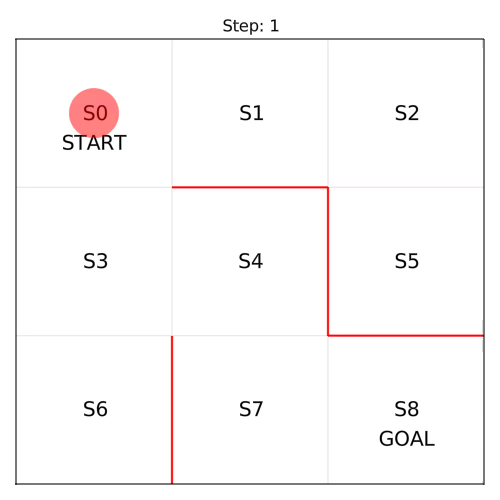

In [5]:
# ランダム行動の結果をプロット
save_anim(env, recorder, "./img/01_04-random-action.gif")
display("image/gif", read("./img/01_04-random-action.gif"))

## パッケージ化

上記で概ねフレームワークの枠組みは出来上がったため、パッケージ化して再利用しやすくする

In [6]:
# Revise パッケージを読み込んで、開発中のパッケージの変更を自動で検知するようにする
using Revise, Pkg

# SimpleRL パッケージ開発
if !isdir("./SimpleRL")
    Pkg.generate("./SimpleRL")
end

Pkg.activate("./SimpleRL")
Pkg.add([
    "Test",
    "GLMakie",
    "NaNStatistics",
    "Distributions",
    "ProgressMeter"
])

  Activating project at `d:\github\julia_ml-tuto\04_reinforcement-learning\pytorch\SimpleRL`
    Updating registry at `C:\Users\user\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `D:\github\julia_ml-tuto\04_reinforcement-learning\pytorch\SimpleRL\Project.toml`
  No Changes to `D:\github\julia_ml-tuto\04_reinforcement-learning\pytorch\SimpleRL\Manifest.toml`


In [7]:
# 開発したパッケージのコンパイルテスト
Pkg.precompile()

In [8]:
# 単体テスト実行
Pkg.test()

     Testing SimpleRL
      Status `C:\Users\user\AppData\Local\Temp\jl_Dgakqn\Project.toml`
  [31c24e10] Distributions v0.25.65
  [e9467ef8] GLMakie v0.6.10
  [b946abbf] NaNStatistics v0.6.13
  [92933f4c] ProgressMeter v1.7.2
  [8f9bf27a] SimpleRL v0.1.0 `D:\github\julia_ml-tuto\04_reinforcement-learning\pytorch\SimpleRL`
  [8dfed614] Test `@stdlib/Test`
      Status `C:\Users\user\AppData\Local\Temp\jl_Dgakqn\Manifest.toml`
  [621f4979] AbstractFFTs v1.2.1
  [1520ce14] AbstractTrees v0.4.2
  [79e6a3ab] Adapt v3.3.3
  [27a7e980] Animations v0.4.1
  [4fba245c] ArrayInterface v6.0.19
  [30b0a656] ArrayInterfaceCore v0.1.14
  [015c0d05] ArrayInterfaceOffsetArrays v0.1.6
  [b0d46f97] ArrayInterfaceStaticArrays v0.1.4
  [dd5226c6] ArrayInterfaceStaticArraysCore v0.1.0
  [67c07d97] Automa v0.8.2
  [13072b0f] AxisAlgorithms v1.0.1
  [62783981] BitTwiddlingConvenienceFunctions v0.1.4
  [fa961155] CEnum v0.4.2
  [2a0fbf3d] CPUSummary v0.1.23
  [49dc2e85] Calculus v0.5.1
  [d360d2e6] ChainRules

Test Summary: | Pass  Total
MazeEnv       |    4      4



  [3fa0cd96] REPL `@stdlib/REPL`
  [9a3f8284] Random `@stdlib/Random`
  [ea8e919c] SHA `@stdlib/SHA`
  [9e88b42a] Serialization `@stdlib/Serialization`
  [1a1011a3] SharedArrays `@stdlib/SharedArrays`
  [6462fe0b] Sockets `@stdlib/Sockets`
  [2f01184e] SparseArrays `@stdlib/SparseArrays`
  [10745b16] Statistics `@stdlib/Statistics`
  [4607b0f0] SuiteSparse `@stdlib/SuiteSparse`
  [fa267f1f] TOML `@stdlib/TOML`
  [a4e569a6] Tar `@stdlib/Tar`
  [8dfed614] Test `@stdlib/Test`
  [cf7118a7] UUIDs `@stdlib/UUIDs`
  [4ec0a83e] Unicode `@stdlib/Unicode`
  [e66e0078] CompilerSupportLibraries_jll `@stdlib/CompilerSupportLibraries_jll`
  [deac9b47] LibCURL_jll `@stdlib/LibCURL_jll`
  [29816b5a] LibSSH2_jll `@stdlib/LibSSH2_jll`
  [c8ffd9c3] MbedTLS_jll `@stdlib/MbedTLS_jll`
  [14a3606d] MozillaCACerts_jll `@stdlib/MozillaCACerts_jll`
  [4536629a] OpenBLAS_jll `@stdlib/OpenBLAS_jll`
  [05823500] OpenLibm_jll `@stdlib/OpenLibm_jll`
  [83775a58] Zlib_jll `@stdlib/Zlib_jll`
  [8e850b90] libblastramp